In [1]:
from scipy.io import loadmat

In [2]:
import numpy as np
from scipy.linalg import expm, logm

In [3]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

### Prepare epoch data for two odors

In [4]:
data_odor = loadmat('/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat')

In [5]:
print(data_odor['trialInfo'].shape)
trial_info = data_odor['trialInfo']

(245, 4)


In [6]:
select_odor_A = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 1)
select_odor_B = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 2)

In [7]:
lfp_odor_A = data_odor['lfpEpoch'][select_odor_A, 2000:4000, 5:15]  # LFP data from channels 5 to 15
lfp_odor_B = data_odor['lfpEpoch'][select_odor_B, 2000:4000, 5:15]

In [8]:
print(lfp_odor_A.shape)
print(lfp_odor_B.shape)

(58, 2000, 10)
(41, 2000, 10)


In [9]:
cov_series_odor_A = np.zeros((10, 50, 10, 10))  # time series of covariance matrices
utv_series_odor_A = np.zeros((10, 50, 55))  # time series of upper triangular vector
for i in range(10):
    for t in range(50):
        lfp_window = lfp_odor_A[i, (t * 10):(t * 10 + 50), :]
        cov = np.cov(lfp_window, rowvar=False)
        cov_series_odor_A[i, t, :, :] = cov
        utv = logm(cov)[np.triu_indices(10)]
        utv_series_odor_A[i, t, :] = utv

In [10]:
cov_series_odor_B = np.zeros((10, 50, 10, 10))  
utv_series_odor_B = np.zeros((10, 50, 55))  
for i in range(10):
    for t in range(50):
        lfp_window = lfp_odor_B[i, (t * 10):(t * 10 + 50), :]
        cov = np.cov(lfp_window, rowvar=False)
        cov_series_odor_B[i, t, :, :] = cov
        utv = logm(cov)[np.triu_indices(10)]
        utv_series_odor_B[i, t, :] = utv

### Dimensionality reduction with PCA

In [11]:
from sklearn.decomposition import PCA

In [12]:
all_vector = np.concatenate([utv_series_odor_A, utv_series_odor_B])
print(all_vector.shape)

(20, 50, 55)


In [13]:
all_vector = all_vector.reshape((1000, 55))
pca = PCA(n_components=10)
pca.fit(all_vector)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))

[0.12222241 0.08162076 0.07231336 0.0454309  0.04285825 0.03960027
 0.03704678 0.03645268 0.0292236  0.02885127]
0.5356202853135444


### Fit Gaussian process model for one component

In [15]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ExpSineSquared

In [70]:
all_principal = pca.transform(all_vector)
y1 = all_principal[:, 0]
print(y1.shape)

(1000,)


In [87]:
time = np.linspace(0, 0.5, 50)
X1 = np.tile(time, 20)
print(X1.shape)
odor = np.asarray([0, 0.1])
X2 = np.repeat(odor, 500)
print(X2.shape)

(1000,)
(1000,)


In [88]:
X = np.zeros((1000, 2))
X[:, 0] = X1
X[:, 1] = X2
#for i in range(20):
#    X[(i * 50):(i * 50 + 50), i + 2] = 0.1

In [97]:
kernel = 1.0 * Matern(length_scale=np.repeat(0.1, 2), length_scale_bounds=(0.1, 0.2), nu=1.5) \
+ WhiteKernel(noise_level=1.0, noise_level_bounds=(0.001, 10.0))

In [98]:
model = GaussianProcessRegressor(kernel=kernel).fit(X, y1)
print(model.kernel_)

0.298**2 * Matern(length_scale=[0.1, 0.2], nu=1.5) + WhiteKernel(noise_level=0.789)


In [99]:
posterior_mean, covariance = model.predict(X, return_cov=True)

In [100]:
print(posterior_mean.shape)

(1000,)


In [101]:
print(covariance.shape)

(1000, 1000)


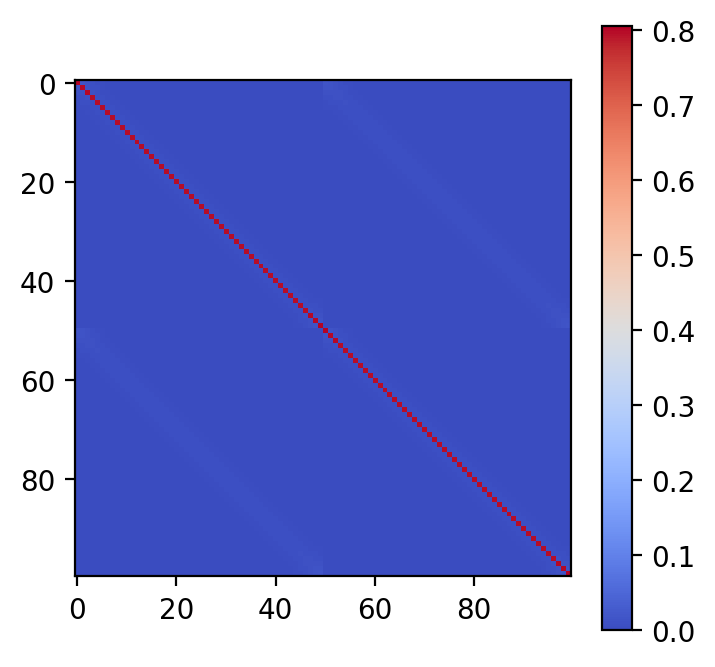

In [104]:
fig = plt.figure(figsize=(4, 4), dpi=200)
plt.imshow(covariance[:100, :100], cmap='coolwarm')
plt.colorbar()
plt.show()

In [522]:
true_series = y1.reshape((20, 50))
posterior_series = posterior_mean.reshape((20, 50))

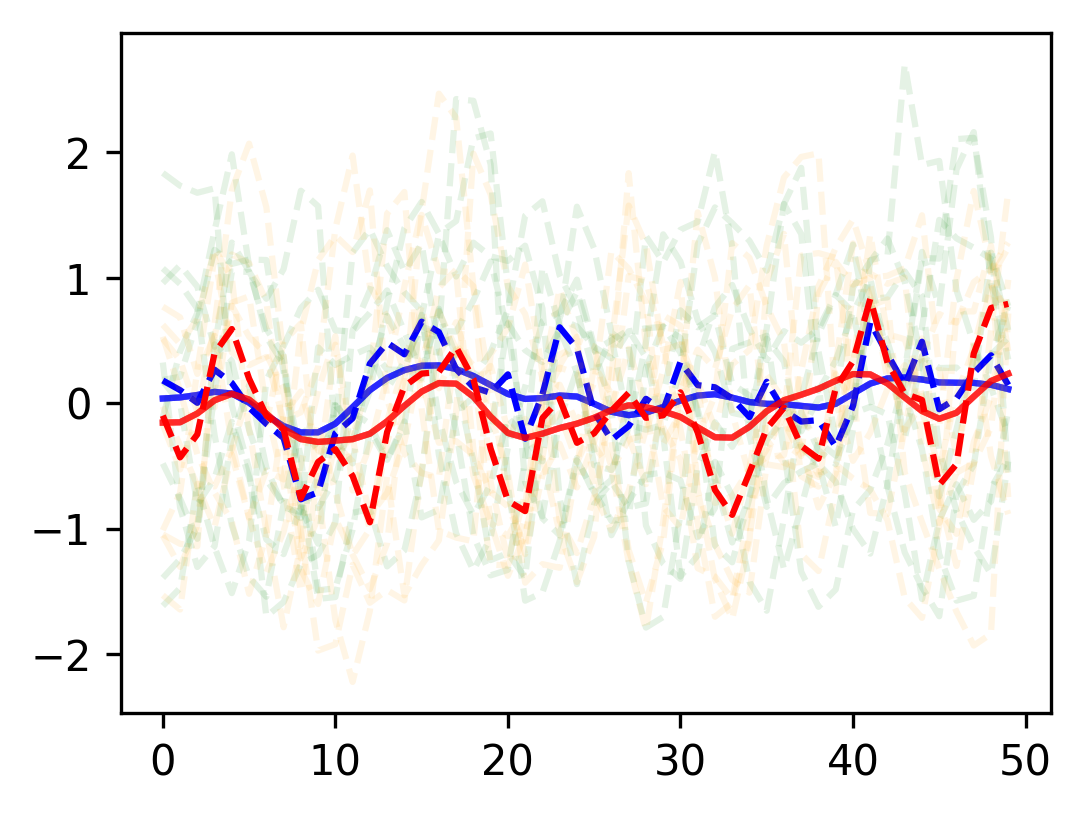

In [523]:
fig = plt.figure(figsize=(4, 3), dpi=300)
for i in range(10):
    plt.plot(true_series[i, :], '--', color='green', alpha=0.1)
    plt.plot(posterior_series[i, :], color='blue', alpha=0.1)
plt.plot(np.median(true_series[:10, ], axis=0), '--', color='blue')
plt.plot(np.median(posterior_series[:10, ], axis=0), alpha=0.5, color='blue')
for i in range(10, 20):
    plt.plot(true_series[i, :], '--', color='orange', alpha=0.1)
    plt.plot(posterior_series[i, :], color='red', alpha=0.1)
plt.plot(np.median(true_series[10:, ], axis=0), '--', color='red')
plt.plot(np.median(posterior_series[10:, ], axis=0), alpha=0.5, color='red')
plt.show()

In [411]:
y2 = all_principal[:, 1]
print(y2.shape)

(4000,)


In [381]:
kernel = Matern(length_scale=0.1, length_scale_bounds=(0.02, 0.5), nu=1.5) \
+ WhiteKernel(noise_level=1.0, noise_level_bounds=(0.1, 10.0))
model = GaussianProcessRegressor(kernel=kernel).fit(X, y2)

In [382]:
print(model.kernel_)

Matern(length_scale=0.0456, nu=1.5) + WhiteKernel(noise_level=0.1)


In [383]:
posterior_mean, covariance = model.predict(X, return_cov=True)

In [384]:
true_series = y2.reshape((40, 50))
posterior_series = posterior_mean.reshape((40, 50))

In [385]:
odor_A_posterior = np.median(posterior_series[:20, ], axis=0)
odor_B_posterior = np.median(posterior_series[20:, ], axis=0)

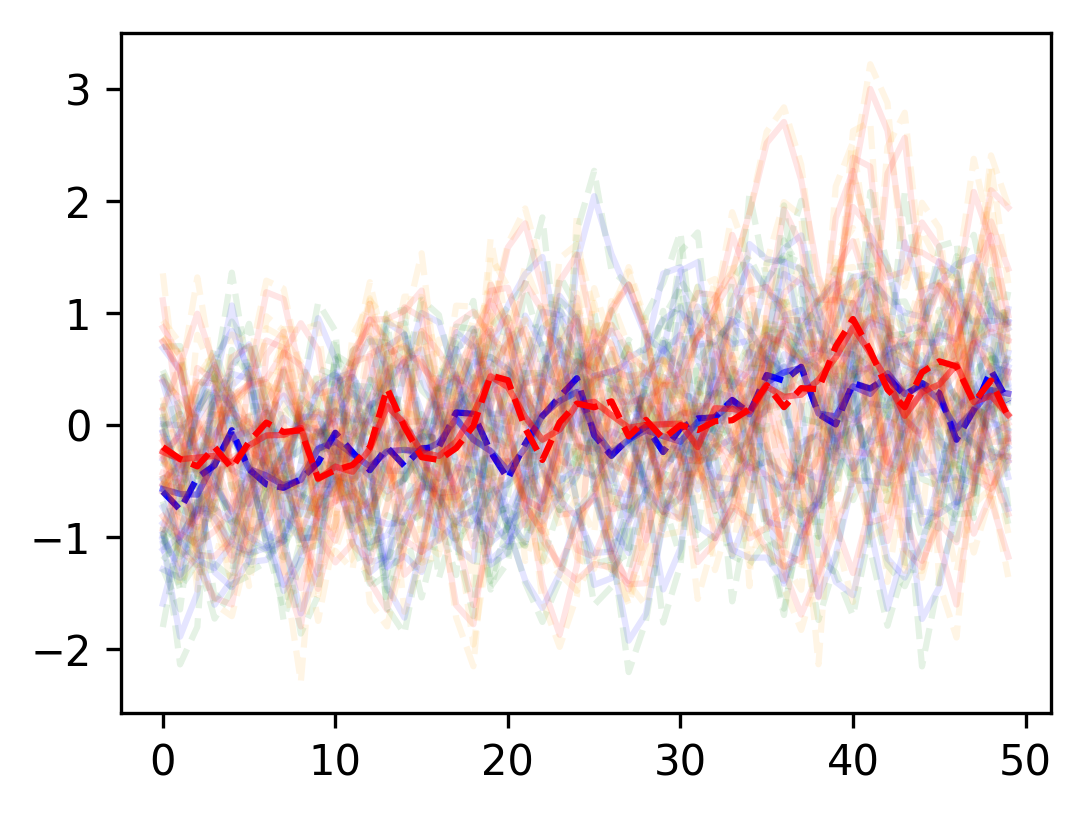

In [386]:
fig = plt.figure(figsize=(4, 3), dpi=300)
for i in range(20):
    plt.plot(true_series[i, :], '--', color='green', alpha=0.1)
    plt.plot(posterior_series[i, :], color='blue', alpha=0.1)
plt.plot(odor_A_posterior, alpha=0.5, color='blue')
plt.plot(np.median(true_series[:20, ], axis=0), '--', color='blue')
for i in range(20, 40):
    plt.plot(true_series[i, :], '--', color='orange', alpha=0.1)
    plt.plot(posterior_series[i, :], color='red', alpha=0.1)
plt.plot(odor_B_posterior, alpha=0.5, color='red')
plt.plot(np.median(true_series[20:, ], axis=0), '--', color='red')
plt.show()